In [1]:
import pandas as pd

In [2]:
baseline_throuhgput_df = pd.read_csv('../router_configs.csv')

# Add 'Time' column starting from 0, increasing by 30 seconds
baseline_throuhgput_df['Time'] = [i * 30 for i in range(len(baseline_throuhgput_df))]
baseline_throuhgput_df = baseline_throuhgput_df[:5]


# Set Time as index and reindex to include every second from 0 to 120
baseline_throuhgput_df.set_index('Time', inplace=True)
baseline_throuhgput_df = baseline_throuhgput_df.reindex(range(0, 121))  # Reindex from 0 to 120
baseline_throuhgput_df.ffill(inplace=True)  # Forward-fill the missing values

# Reset index so Time is a column again
baseline_throuhgput_df = baseline_throuhgput_df.reset_index().rename(columns={'index': 'Time'})

print(baseline_throuhgput_df)

     Time  thrpt  latency  ber_qpsk  loss_pct
0       0  184.0      6.0  0.117095      12.0
1       1  184.0      6.0  0.117095      12.0
2       2  184.0      6.0  0.117095      12.0
3       3  184.0      6.0  0.117095      12.0
4       4  184.0      6.0  0.117095      12.0
..    ...    ...      ...       ...       ...
116   116  430.0      6.0  0.012877       1.0
117   117  430.0      6.0  0.012877       1.0
118   118  430.0      6.0  0.012877       1.0
119   119  430.0      6.0  0.012877       1.0
120   120  336.0      6.0  0.034279       3.0

[121 rows x 5 columns]


In [ ]:
import dpkt
import os
import pandas as pd
from utils.util import create_directory_if_not_exists, find_files_with_extension
from utils.plotter import plot_siftr_graph


# Convert bytes to Mbit/s
def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

# Read pcap file and get throughput per second for specific ports
def read_pcap(file_path):
    ports = [5101, 5102, 5103, 5106, 8082]
    throughput_per_second = {port: {} for port in ports}
    goodput_per_second = {port: {} for port in ports}
    total_throughput = {port: 0 for port in ports}
    total_goodput = {port: 0 for port in ports}

    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            l4 = ip.data  # TCP or UDP

            if isinstance(l4, (dpkt.tcp.TCP, dpkt.udp.UDP)):
                dest_port = l4.dport
                if dest_port not in throughput_per_second:
                    continue

                pkt_length = len(buf)
                l4_hdr_len = 0

                # Estimate L4 header length
                if isinstance(l4, dpkt.tcp.TCP):
                    l4_hdr_len = (l4.off * 4)  # TCP offset is in 32-bit words
                elif isinstance(l4, dpkt.udp.UDP):
                    l4_hdr_len = 8  # UDP header is fixed at 8 bytes

                app_payload_len = len(l4.data)

                if start_time is None:
                    start_time = timestamp

                normalized_time = int(timestamp - start_time)

                # Throughput (includes headers)
                if normalized_time not in throughput_per_second[dest_port]:
                    throughput_per_second[dest_port][normalized_time] = pkt_length
                else:
                    throughput_per_second[dest_port][normalized_time] += pkt_length

                # Goodput (payload only)
                if normalized_time not in goodput_per_second[dest_port]:
                    goodput_per_second[dest_port][normalized_time] = app_payload_len
                else:
                    goodput_per_second[dest_port][normalized_time] += app_payload_len

                total_throughput[dest_port] += pkt_length
                total_goodput[dest_port] += app_payload_len

    return throughput_per_second, goodput_per_second, total_throughput, total_goodput


# Plot throughput using plot_siftr_graph
def plot_throughput_with_siftr(file_path, ycolumn, title, xlabel, ylabel, filename, graph_directory, use_goodput=False):
    throughput, goodput, total_thrpt, total_goodpt = read_pcap(file_path)

    
    data_source = goodput if use_goodput else throughput
    total_source = total_goodpt if use_goodput else total_thrpt

    print(total_source.items())

    paths = {}
    print(f"Total {'goodput' if use_goodput else 'throughput'} for {filename}: {total_source}")
    print(data_source.items())

    for port, data in data_source.items():
        if port not in [5102, 5106]:
            continue
        sorted_data = sorted(data.items())
        times = [item[0] for item in sorted_data]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_data]

        path_df = pd.DataFrame({'Time': times, ycolumn: mbits_transferred})
        path_label = f"Port {port}"
        if port == 5106:
            path_label = "UDP-Prague"
        if port == 5102:
            path_label = "Cubic"

        paths[path_label] = path_df
    baseline_throuhgput_df.rename(columns={'thrpt': ycolumn}, inplace=True)
    # path_df.to_csv("temp_hrpt.csv", index=False)   
    paths['Baseline Throuhgput'] = baseline_throuhgput_df
    paths['UDP-Prague'].to_csv("./graph_data/udp_prague_thrpt.csv")
    paths['Cubic'].to_csv("./graph_data/cubic_thrpt.csv")
    paths['Baseline Throuhgput'].to_csv("./graph_data/baseline_throughput.csv")
    
    create_directory_if_not_exists(graph_directory)
    filename = str("Thrpt_UDPPraguevsCubic")
    plot_siftr_graph(paths, ycolumn, title, xlabel, ylabel, filename, graph_directory)


# Main execution

mainpth="../data/udp_net_2025-06-10-13-27-49"
# mainpth="../data/udp_net_2025-06-04-07-56-54"

graph_directory = os.path.join("./", "Graphs")
create_directory_if_not_exists(graph_directory)

folderpath = os.path.join(mainpth, "")

# Use the new find_files_with_extension function
filenames, filepaths, file_dict = find_files_with_extension(paths=[folderpath], extension='.pcap')

from utils.thrpt_util import analysis_pcap_tcp

Directory already exists: ./Graphs


In [4]:
# # Plot throughput for each pcap file
# for filename, filepath in zip(filenames, filepaths):
#     print(filename)
#     analysis_pcap_tcp(filepath)

In [5]:
filepaths

['../data/udp_net_2025-06-10-13-27-49\\pcap_server_iperf3_d1800.pcap']

In [6]:
baseline_throuhgput_df

,Time,thrpt,latency,ber_qpsk,loss_pct
0,0,184.0,6.0,0.117095,12.0
1,1,184.0,6.0,0.117095,12.0
2,2,184.0,6.0,0.117095,12.0
3,3,184.0,6.0,0.117095,12.0
4,4,184.0,6.0,0.117095,12.0
...,...,...,...,...,...
116,116,430.0,6.0,0.012877,1.0
117,117,430.0,6.0,0.012877,1.0
118,118,430.0,6.0,0.012877,1.0
119,119,430.0,6.0,0.012877,1.0


dict_items([(5101, 0), (5102, 2616869728), (5103, 0), (5106, 1761081068), (8082, 0)])
Total throughput for pcap_server_iperf3_d1800.pcap_throughput: {5101: 0, 5102: 2616869728, 5103: 0, 5106: 1761081068, 8082: 0}
dict_items([(5101, {}), (5102, {0: 17961840, 1: 19373362, 2: 17785880, 3: 16017292, 4: 15383856, 5: 15215122, 6: 14120122, 7: 13444012, 8: 11637438, 9: 11904124, 10: 9756300, 11: 10765868, 12: 10326244, 13: 12657690, 14: 12121700, 15: 12426190, 16: 11690152, 17: 13866170, 18: 12249280, 19: 10987908, 20: 11462020, 21: 11407848, 22: 10186654, 23: 9883028, 24: 9468410, 25: 11081494, 26: 11586416, 27: 10749990, 28: 10908430, 29: 9220946, 30: 12293858, 31: 9297560, 32: 10086206, 33: 15229428, 34: 18909382, 35: 18978714, 36: 18017238, 37: 14417526, 38: 15722490, 39: 15469294, 40: 18784538, 41: 16984546, 42: 16782936, 43: 16542214, 44: 15201008, 45: 16573088, 46: 16520736, 47: 14649682, 48: 18552100, 49: 17325912, 50: 13456666, 51: 12306164, 52: 11170870, 53: 14320294, 54: 17312372, 

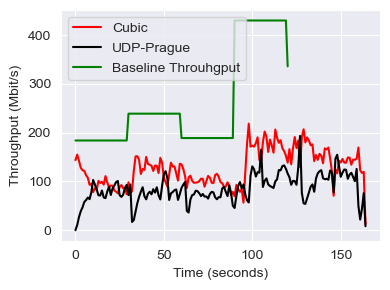

In [7]:
# Plot throughput for each pcap file
for filename, filepath in zip(filenames, filepaths):
    plot_throughput_with_siftr(
        file_path=filepath,
        ycolumn="Throughput (Mbit/s)",
        title=f"Throughput for {filename}",
        xlabel="Time (seconds)",
        ylabel="Throughput (Mbit/s)",
        filename=f"{filename}_throughput",
        graph_directory=graph_directory
    )